In [1]:
%cd ../src
%ls

/home/roland/Desktop/Stage_4A/higher-order-diffusion/src
datasets/           data_types.py  __init__.py  __pycache__/  training/  viz/
data_transforms.py  diffusion/     models/      samplers/     utils/


In [2]:
import diffusion as diffusion_lib
import diffusion.beta_schedule as schedule_lib
import samplers as sampler_lib
import training.time_sampler as time_sampler_lib
import datasets as dataset_lib
import training.losses as loss_lib
import training.train as train_lib
import utils.config as config_lib
import models.mlp as model_lib
import utils.logging as loglib

import flax
import jax
import jax.numpy as jnp
import optax
import functools
import copy

import matplotlib.pyplot as plt
import numpy as np
import einops
import time

/home/roland/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
# input parameters
# --------------------------------------------
# training
batch_size = 128
seed = 42
rng = jax.random.PRNGKey(seed)
num_training_iterations = 100_000
ema_rate = 0.99
num_devices = jax.local_device_count()

# optimizer
optimizer_config = config_lib.Config(learning_rate=2e-4) #, b1=0.9, b2=0.999, eps=1e-8)
scheduler_config = config_lib.Config(init_value=1.0, decay_steps=1_000, alpha=0.0)

# dataset
# dataset_name = "CIFAR10"
# image_size = 32
# data_shape = (image_size, image_size, 3)
dataset_name = dataset_lib.MOON
data_shape = (2,)

# diffusion
T_max = 1.0
t_0 = 1e-4
num_timesteps = 1000

beta_max = 10.0
beta_min = 0.01

mean_T = jnp.zeros(data_shape)
sigma_T = 4*jnp.ones(data_shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# Set up
# --------------------------------------------
# --------------------------------------------

# data
# --------------------------------------------
train_ds, eval_ds = dataset_lib.get_dataset(
    dataset_name,
    train_batch_size=batch_size,
    eval_batch_size=batch_size,
    num_jit_steps=None,
    image_size=None,
    random_flip=None,
    data_category=None,
    uniform_dequantization=False,
    num_two_dim_samples=10_000,
)
train_iter = iter(train_ds)

# set up data transform
transform_fn = lambda x: x

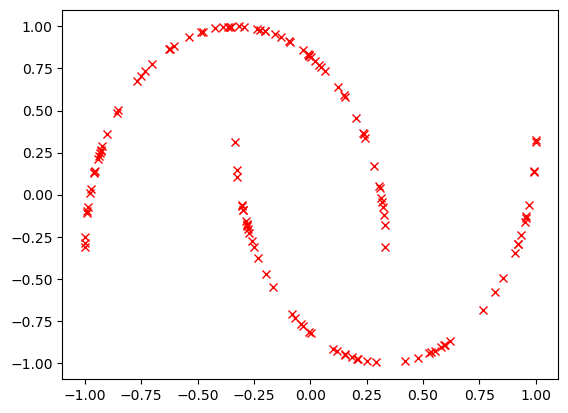

In [5]:
batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
x = batch['x']
plot_x = x[0]
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')

In [6]:
# forward diffusion
# --------------------------------------------
beta_schedule = schedule_lib.LinearSchedule(
    beta_0=beta_min, beta_T=beta_max, t_0=0, T=T_max
)
state_sampler = sampler_lib.get_ornstein_uhlenbeck_sampler(
    mean_T=mean_T, sigma_T=sigma_T, beta_schedule=beta_schedule
)
drift_fn, diffusion_scale_fn = diffusion_lib.get_ornstein_uhlenbeck_diffusion(
    mean_T=mean_T, sigma_T=sigma_T, beta_schedule=beta_schedule
)

# set up time sampler
time_sampler = functools.partial(
    time_sampler_lib.uniform_time_sampler, t_0=t_0, T=T_max
)
noising_fn = sampler_lib.get_noising_fn(time_sampler, state_sampler)

In [7]:
beta_schedule.integral_beta_t(T_max), T_max

(5.005, 1.0)

(Array([-0.42204875,  0.04161163], dtype=float32),
 Array([3.4966984, 3.5274687], dtype=float32))

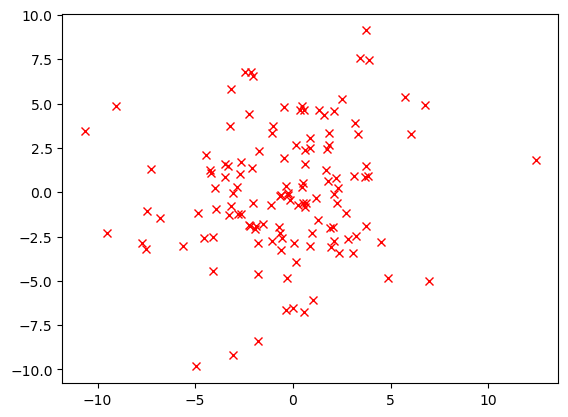

In [8]:
init_t = jnp.zeros((batch_size,))
init_x = x[0]
init_rng = jax.random.PRNGKey(0)

init_state = diffusion_lib.init_diffusion_state(
        x_init=init_x, t_init=init_t, rng=init_rng
    )
t = jnp.ones((batch_size))*T_max
forward_state = state_sampler(init_state, t)
plot_x = forward_state.x_t
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')
plot_x.mean(0), plot_x.std(0)

In [9]:
# model
# --------------------------------------------
model = model_lib.MLPDiffusionModel()

# training
# --------------------------------------------
# set up optimizer
schedule_fn = optax.cosine_decay_schedule(**scheduler_config.as_dict())
optimizer = optax.chain(
    optax.adam(**optimizer_config.as_dict())
#     , optax.scale_by_schedule(schedule_fn)
)


def weight_fn(forward_state):
    int_t =  beta_schedule.integral_beta_t(forward_state.t)-beta_schedule.integral_beta_t(t_0)
    _, std = sampler_lib.compute_ou_moments(mean_T, sigma_T, forward_state.x_0, int_t)
    return 1 / (1e-3+std[:,0])

# setup training step
loss_fn = loss_lib.get_matching_loss_fn(
    model=model,
    weight_fn=weight_fn
)
train_step = train_lib.get_train_step_fn(
    loss_fn=loss_fn,
    optimizer=optimizer,
    ema_rate=ema_rate,
    noising_fn=noising_fn,
)

In [10]:
# def weight_fn(t):
#     _, std = sampler_lib.compute_ou_moments(mean_T, sigma_T, jnp.ones((t.shape[0], *mean_T.shape)), 
#                                             t=beta_schedule.integral_beta_t(T_max - t))
#     return 1 / std[:,0]

# rng, step_rng = jax.random.split(rng)
# t = time_sampler(step_rng, (128,))
# jnp.sum(weight_fn(t)), jnp.where(weight_fn(t)==weight_fn(t).max())

In [11]:
# init training state
# --------------------------------------------
dummy_x = jnp.ones((1, *data_shape))
dummy_t = jnp.ones((1,))
rng, init_rng = jax.random.split(rng)

model_vars = model.init(rng, dummy_x, dummy_t)
model_state, params = model_vars.pop("params")
opt_state = optimizer.init(params)


# setup train state
train_state = train_lib.TrainState(
    step=0,
    params=params,
    model_state=model_state,
    opt_state=opt_state,
    ema_params=copy.deepcopy(params),
)

In [12]:
p_train_step = jax.pmap(train_step, axis_name="batch", donate_argnums=1)
pstate = flax.jax_utils.replicate(train_state)

In [13]:
# training loop
# --------------------------------------------
start_time = time.time()
losses = []
for it in range(num_training_iterations):
    rng, train_rng, time_rng, init_rng = jax.random.split(rng, 4)
    batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
    x = batch["x"]
    z = transform_fn(x)

    init_t = jnp.zeros((num_devices, batch_size))
    init_rng = jax.random.split(init_rng, num_devices)
    init_state = diffusion_lib.init_diffusion_state(
        x_init=z, t_init=init_t, rng=init_rng
    )

    # rng per device
    train_rng = jnp.asarray(jax.random.split(train_rng, num_devices))

    # train step
    carry_state = (train_rng, pstate)
    (_, pstate), (loss, step) = p_train_step(
        carry_state,
        init_state,
    )
    
    
    # metrics
    if it % 500 == 0:
        losses.append(loss.item())
        runtime = time.time() - start_time
        train_state = flax.jax_utils.unreplicate(pstate)
        print_metrics = {"step": step, "loss": loss, "runtime": runtime}
        loglib.print_metrics(print_metrics)

step: 1 - loss: 1.088550 - runtime: 2.086204
step: 501 - loss: 0.749883 - runtime: 4.717040
step: 1001 - loss: 0.436470 - runtime: 7.519217
step: 1501 - loss: 0.686993 - runtime: 10.027681
step: 2001 - loss: 1.113527 - runtime: 12.535825
step: 2501 - loss: 2.773463 - runtime: 15.015591
step: 3001 - loss: 0.890139 - runtime: 17.500103
step: 3501 - loss: 0.776176 - runtime: 20.017611
step: 4001 - loss: 0.546896 - runtime: 22.498662
step: 4501 - loss: 0.444337 - runtime: 24.944401
step: 5001 - loss: 0.669289 - runtime: 27.436776
step: 5501 - loss: 1.470991 - runtime: 29.889188
step: 6001 - loss: 0.849108 - runtime: 32.354373
step: 6501 - loss: 0.638165 - runtime: 34.859857
step: 7001 - loss: 2.193640 - runtime: 37.304049
step: 7501 - loss: 0.698751 - runtime: 39.784798
step: 8001 - loss: 0.561547 - runtime: 42.264875
step: 8501 - loss: 0.859204 - runtime: 44.731337
step: 9001 - loss: 0.239664 - runtime: 47.213874
step: 9501 - loss: 0.969830 - runtime: 49.636065
step: 10001 - loss: 0.79284

KeyboardInterrupt: 

In [ ]:
import models.model_utils as mutils
import diffusion.transforms as transforms
from samplers import euler_maruyama
import utils.math as ops

In [ ]:
rev_score_fn = mutils.get_model_fn(
    model,
    train_state.ema_params,
    train_state.model_state,
    train=False,
)


rng = jax.random.PRNGKey(0)
rng, rng_step = jax.random.split(rng)
batch_size = 512
x_init = jax.random.normal(rng, (batch_size, *data_shape))
t_init = jnp.zeros((batch_size,))


init_diffusion_state = diffusion_lib.init_diffusion_state(
    x_init=x_init, t_init =t_init, rng=rng
)


def weight_fn(t):
    _, std = sampler_lib.compute_ou_moments(mean_T, sigma_T, jnp.ones((t.shape[0], *mean_T.shape)), 
                                            t=beta_schedule.integral_beta_t(T_max - t))
    return 1 / std[:,0]

def score_fn(x,t):
    
    score_fn = transforms.reverse_time_argument(rev_score_fn, argnum=1, T_max=T_max)
    return ops.batch_mul(score_fn(x,t), weight_fn(t))



backward_drift_fn, backward_scale_fn = transforms.time_reversal(forward_drift_fn=drift_fn, 
                         forward_diffusion_scale_fn=diffusion_scale_fn, 
                         reverse_score_fn=score_fn, T_max=T_max)

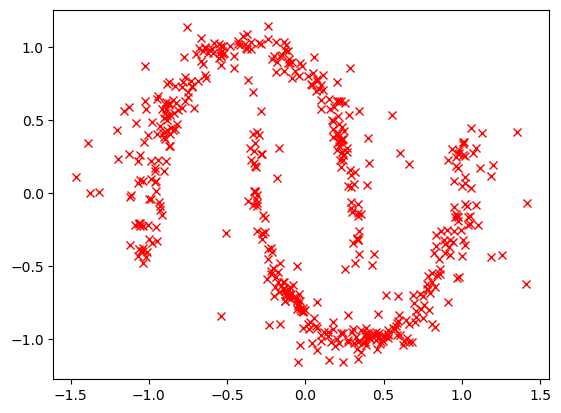

In [ ]:

n_steps = 1000
step_schedule = T_max*jnp.ones(n_steps) / n_steps

diffusion_state = euler_maruyama(
    diffusion_state=init_diffusion_state,
    step_schedule=step_schedule,
    drift_fn=backward_drift_fn,
    diffusion_scale_fn=backward_scale_fn,
    return_trajectory=False
)
plot_x = diffusion_state['x_t']
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')

In [ ]:
diffusion_state = euler_maruyama(
    diffusion_state=init_diffusion_state,
    step_schedule=step_schedule,
    drift_fn=backward_drift_fn,
    diffusion_scale_fn=backward_scale_fn,
    return_trajectory=True
)
plot_x = diffusion_state['mean_t']

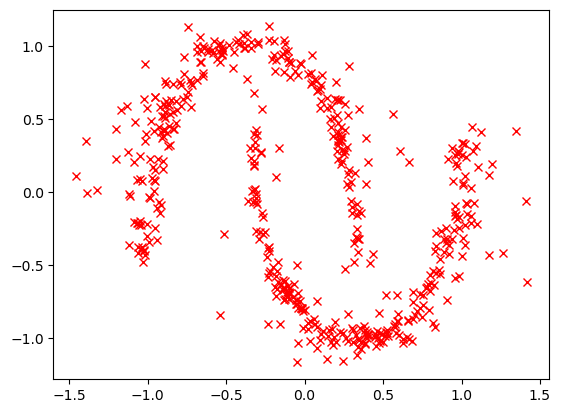

In [ ]:
plt.plot(plot_x[-1, :,0], plot_x[-1, :,1], 'rx')

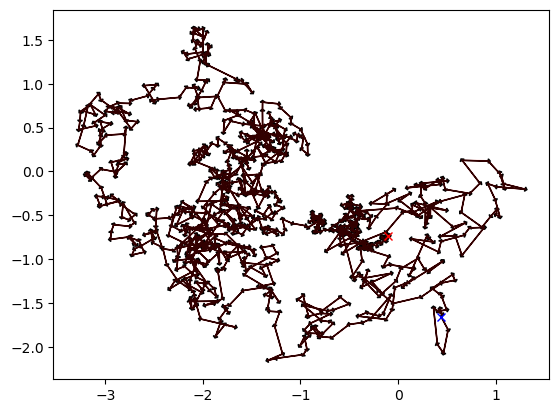

In [ ]:
plt.plot(plot_x[:, 0,0], plot_x[:, 0,1], 'r', alpha=0.2)
x, y = plot_x[0, 0,0], plot_x[0, 0,1]
for next_x, next_y in zip(plot_x[1:, 0,0], plot_x[1:, 0,1]):
    dx, dy = next_x-x, next_y - y
    plt.arrow(x, y, dx, dy, head_width=0.05, head_length=0.02)
    x, y = next_x, next_y
    
plt.plot(plot_x[-1, 0,0], plot_x[-1, 0,1], 'rx')
plt.plot(plot_x[0, 0,0], plot_x[0, 0,1], 'bx')

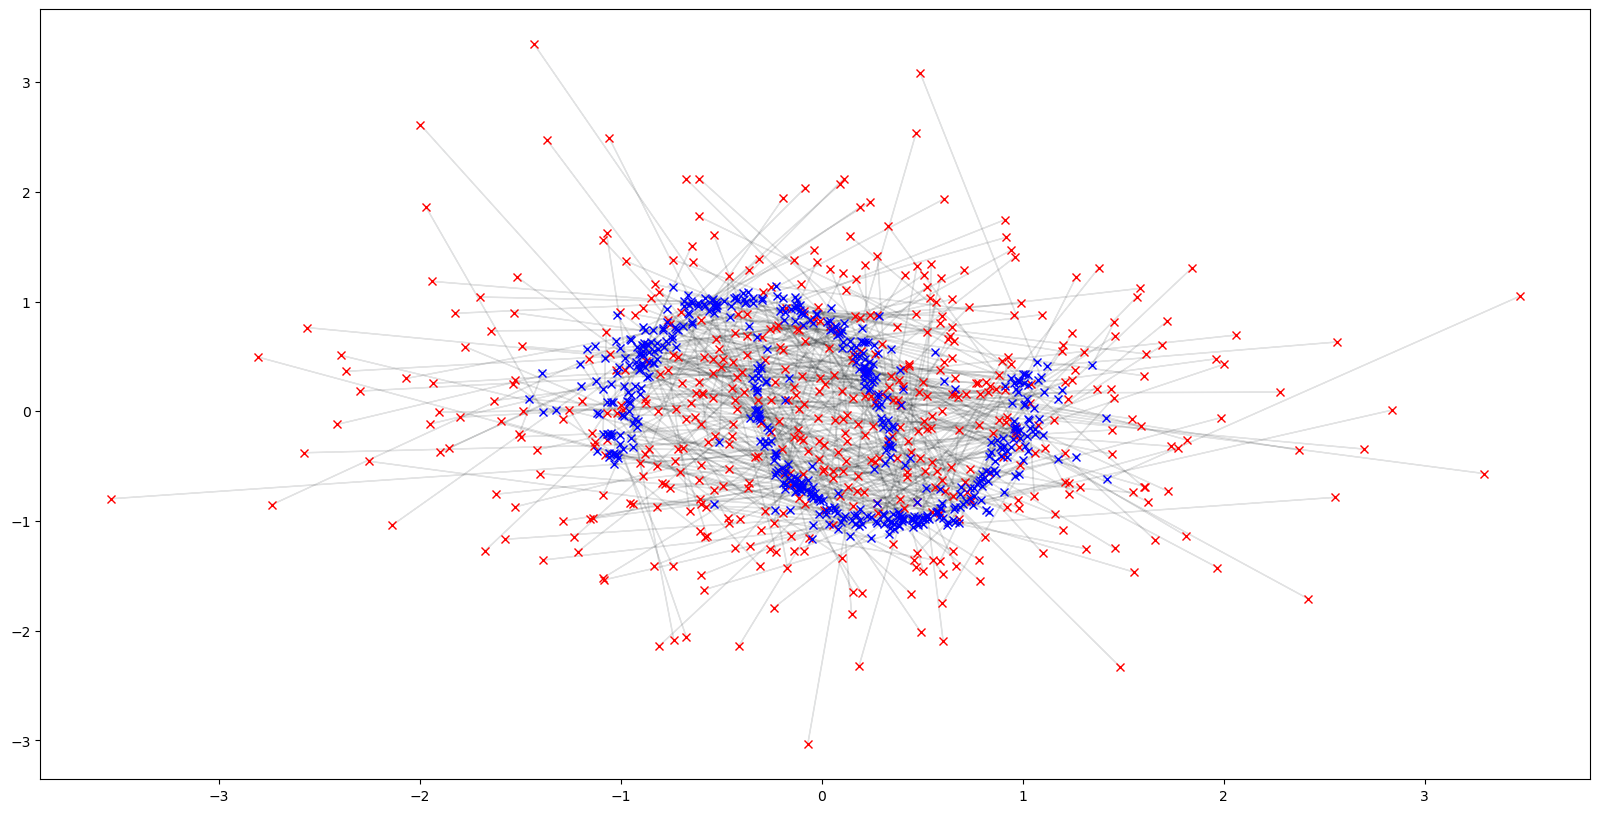

In [ ]:
plt.figure(figsize=(20,10))
x_0, y_0 = plot_x[0, :,0], plot_x[0, :,1]
x_T, y_T = plot_x[-1, :,0], plot_x[-1, :,1]
dx, dy = x_T - x_0, y_T - y_0

plt.plot(x_0, y_0, 'rx')
plt.plot(x_T, y_T, 'bx')

for item in zip(x_0, y_0, dx, dy):
    plt.arrow(*item, head_width=0.05, head_length=0.02, alpha=0.1)

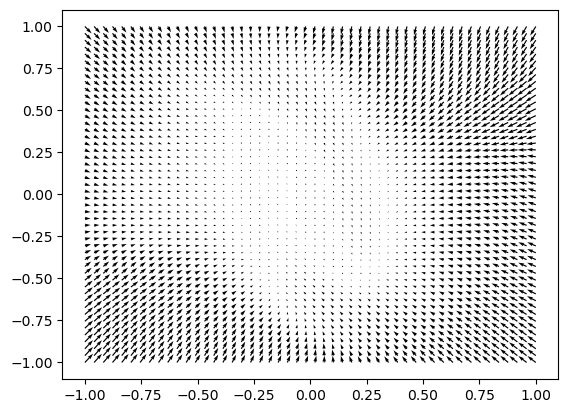

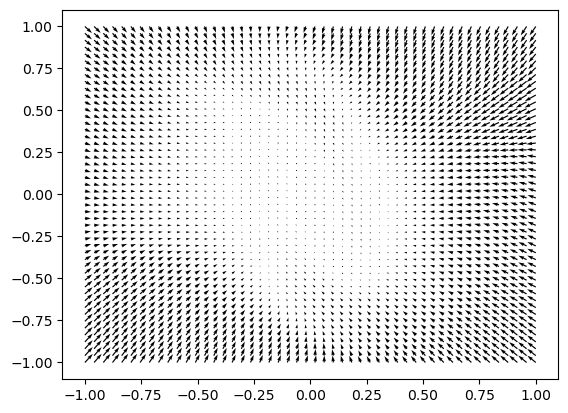

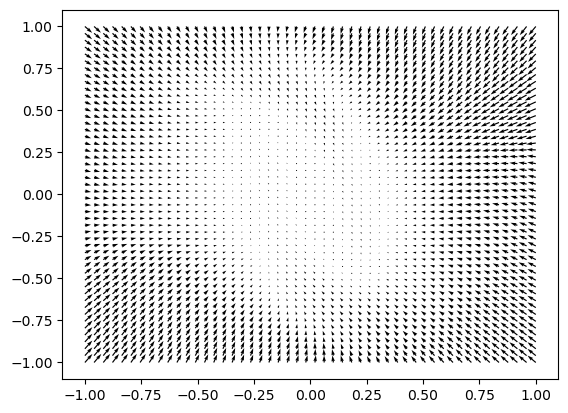

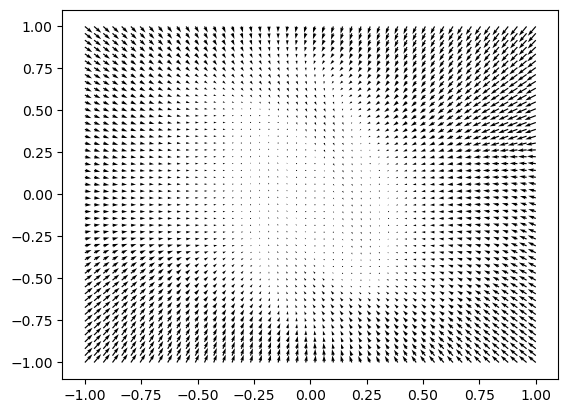

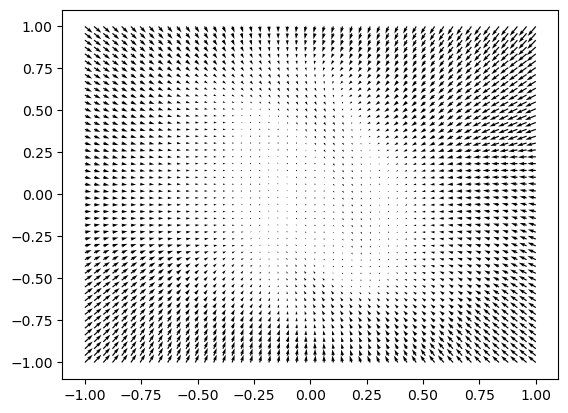

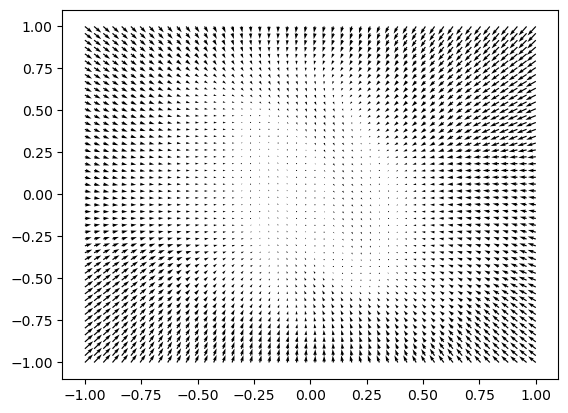

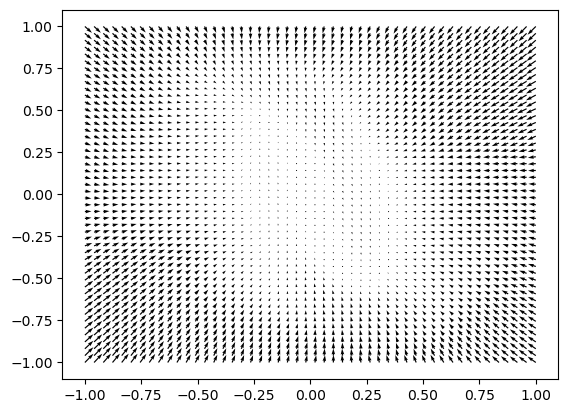

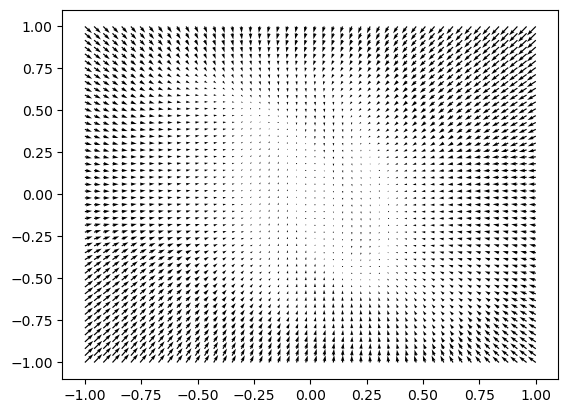

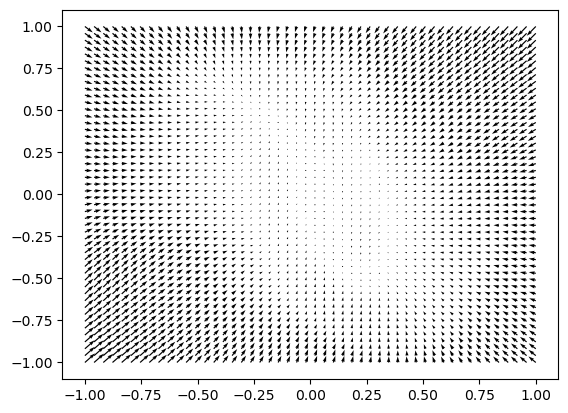

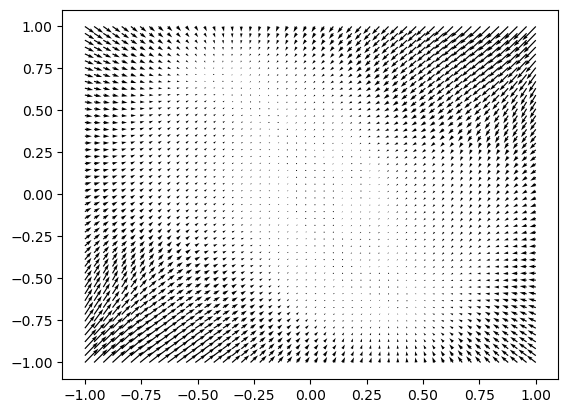

In [ ]:
grid_w = 1
res = 50
x,y = jnp.meshgrid(np.linspace(-grid_w,grid_w,res),np.linspace(-grid_w,grid_w,res))
x.shape, y.shape
flat_x = einops.rearrange(x, 'a b -> (a b)')
flat_y = einops.rearrange(y, 'a b -> (a b)')
network_input = jnp.stack([flat_x, flat_y], -1)
    
for t in jnp.arange(t_0, T_max, T_max/10):

    t = jnp.ones(network_input.shape[0])*t
    score = score_fn(x=network_input, t=t)
    dx, dy = jnp.split(score, 2, axis=-1)
    plt.quiver(flat_x, flat_y,dx,dy)
    plt.show()